<a href="https://colab.research.google.com/github/MartinaJoergensen/FirstCodes/blob/master/basic_samplesol_ExamExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exam Exercise

We will use the hls4ml dataset, that inclides simulations of jets produced in LHC collisions.

Jets are cone-shaped sprays of particles produced when gluons or quarks emerge from LHC collisions: quarks and gluons cannot live alone, so they start a shower of other quarks and gluons that then combine among themselves to give the stable particles that we observe in the detector.

Jets can be produced from the deacy of heavy particles, like W boson and Z boson (decaying to pairs of quarks), Higgs bosons (decaying to pairs of quarks), or top quark (decaying to three quarks). When a heavy particle is produced with large momentum, the jets it produces overlap and merge into a single jet, that looks different because of its different internal structure.
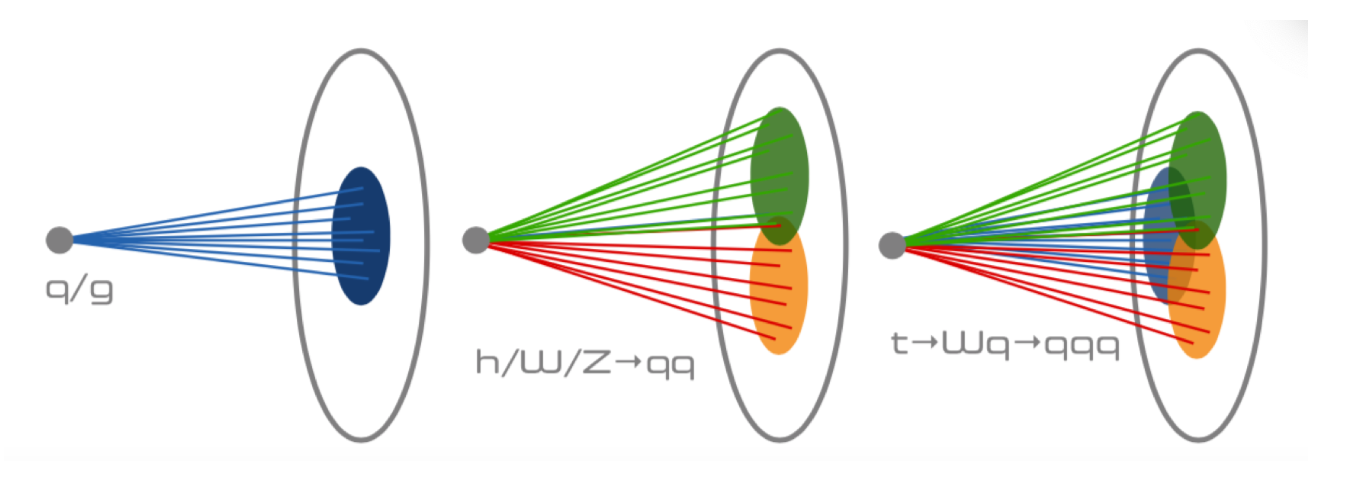


The data are provided in three formats:
- high-level features: an array of physics informed features, engineered to discriminate among the various particles
- Jets as images: a pixelated image of the jet, obtained binning the plane transverse to the jet flight direction and counting the total momentum of the final-state particles flowing in that bin
- Jets as sequence: a list of the particles in the jet, ordered in decreasing momentum, each characterized through a list of physics-informed and particle-specific features

The exercise is divided in two tasks:
- Train  a classifier to identify which particle generated the jets (a task called jet tagging), choosing among the following five possibilities: gluons (g), quarks (q), W bosons (W), Z bosons (Z), and top quarks (t). For this task, you should provide a successful training history, a ROC curve plot with the five classes projected, and a confusion matrix.
- Train an AE on quarks and gluons, to identify W, Z and t jets as anomalies. For this task, you should provide a successful training history, a plot showing the distribution of the loss for the standard jets and for the three anomaly classes, and a ROC curve plot with the three anomaly classes.

You can use one or more data representations at once. The examples in the datasets are in sync (the i-th entry of each dataset corresponds to the same jet) and the ground truth refers to all of them.

The rest of this notebook give you some hint on how to handle the datasets.

In [ ]:
# Get the data
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

fatal: destination path 'tutorials' already exists and is not an empty directory.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Open one file
fileIN = 'tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


The first 100 highest-momentum particles are considered for each jet
- 'jetImage' contains the image representation of the jets (more later)
- 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)
- 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored
- 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
- 'jets' is the dataset we consider for the moment
- 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'

# The Groung Truth

The ground truth is one-hot encoded in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] format, so that
- [1, 0, 0, 0, 0] for gluons
- [0, 1, 0, 0, 0] for quarks
- [0, 0, 1, 0, 0] for Ws
- [0, 0, 0, 1, 0] for Zs
- [0, 0, 0, 0, 1] for tops
The information is contained at the end of the feature vector

In [ ]:
jet_data = np.array(f.get('jets')) # 2D Array
target = jet_data[:,-6:-1] #all rows, but only the last 5 columns
# shape of the dataset
print("Dataset shape:")
print(target.shape)
print("First five entries:")
for i in range(5):
    print(target[i])
print("Last 5 entries:")
for i in range(-5,0):
    print(target[i])

Dataset shape:
(10000, 5)
First five entries:
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
Last 5 entries:
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]


# The physics-informed high-level features

In [ ]:
# These are the quantities we are dealing with
featurenames = f.get('jetFeatureNames')
print(featurenames[:])
print(featurenames, type(featurenames)) #the high level features
# the b is due to the byte vs utf-8 encoding of the strings in the dataset
# just ignore them for the moment

[b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'j_t' b'j_undef']
<HDF5 dataset "jetFeatureNames": shape (59,), type "|O"> <class 'h5py._hl.dataset.Dataset'>


53


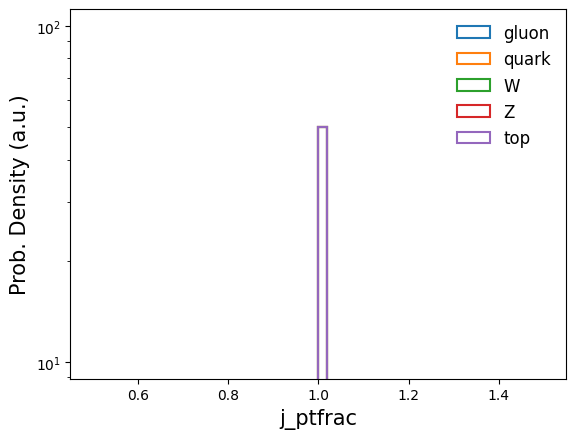

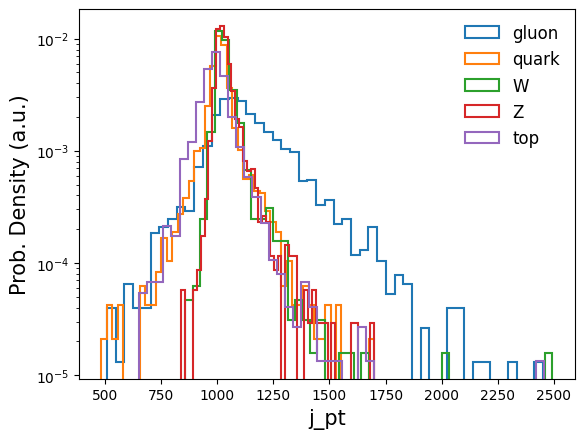

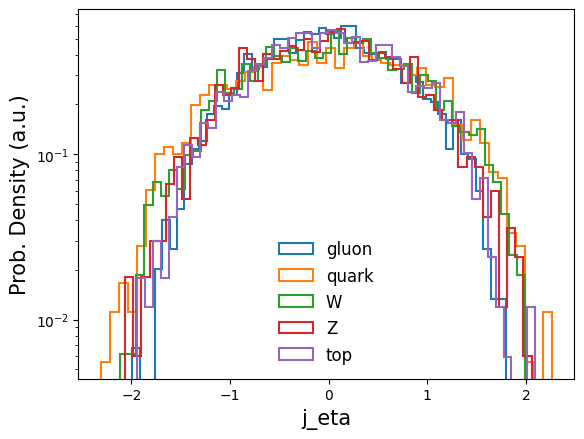

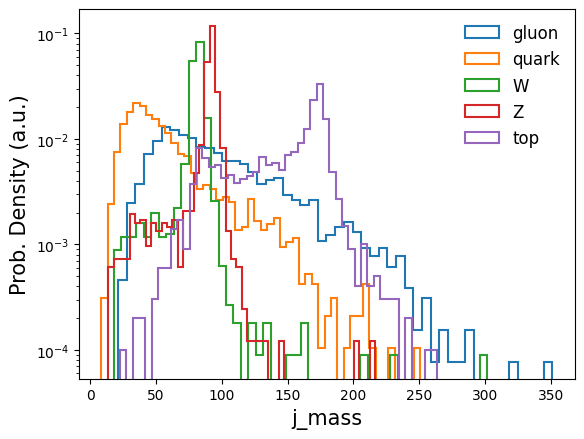

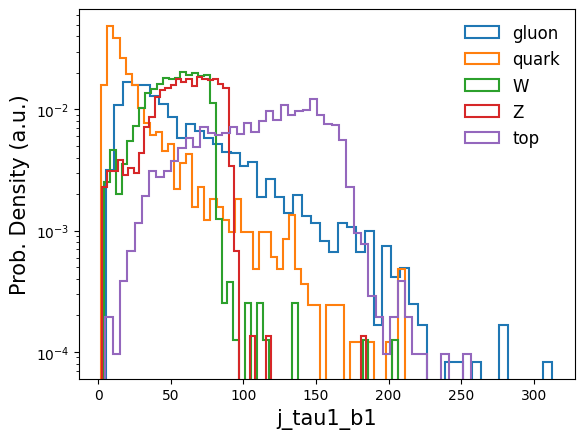

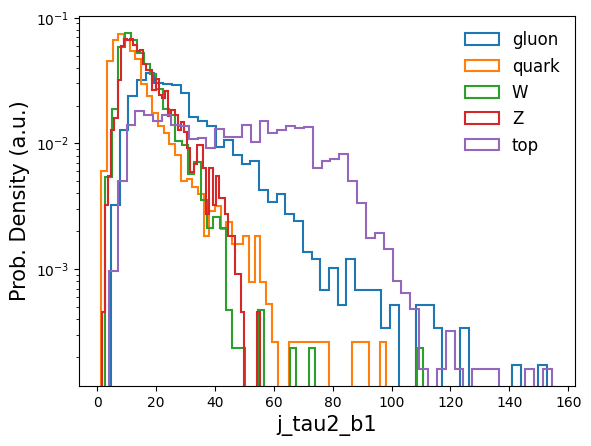

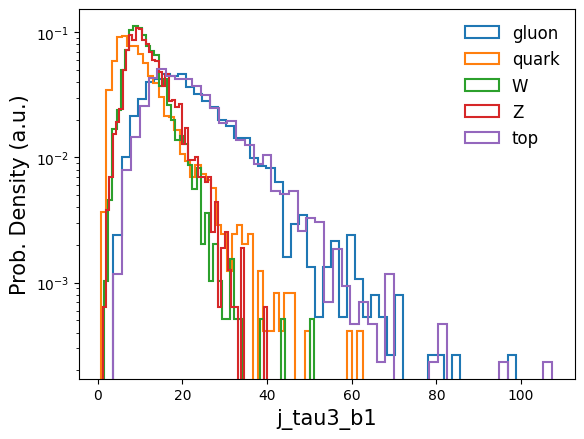

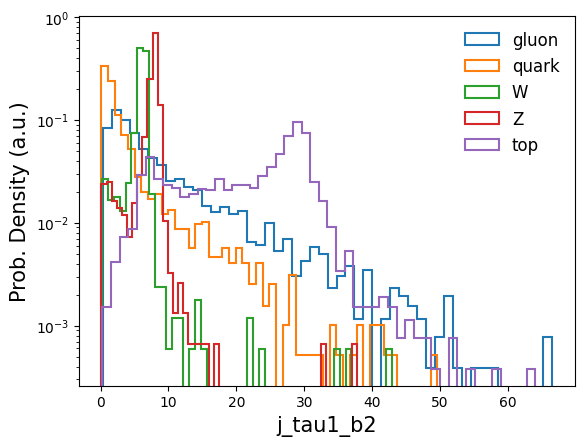

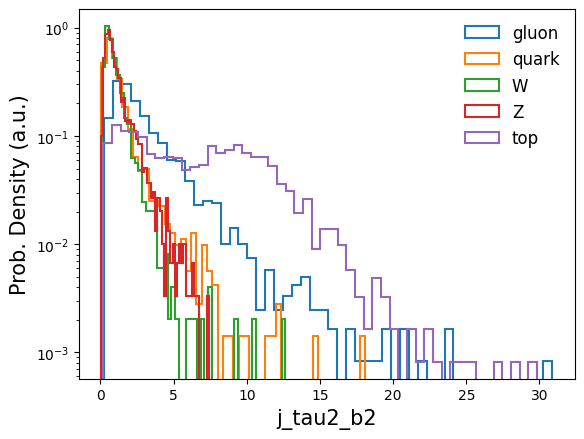

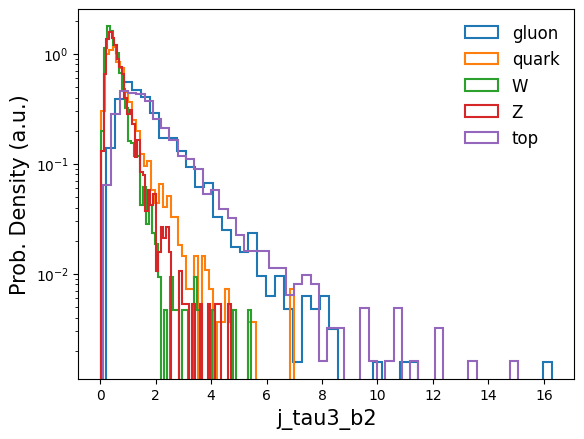

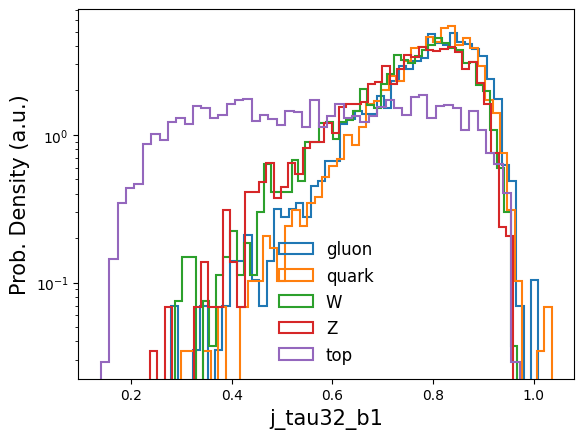

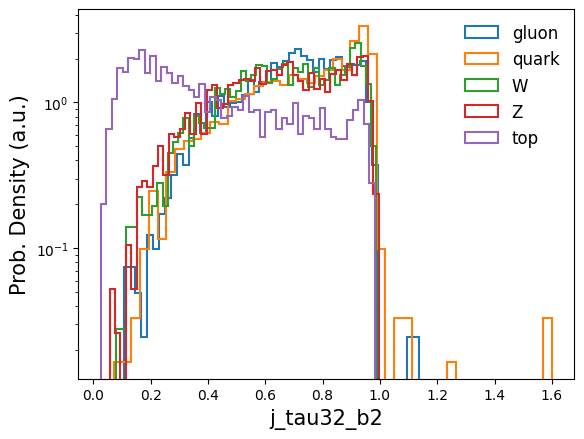

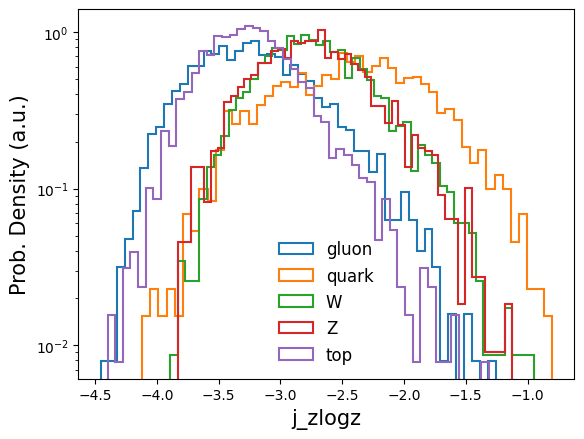

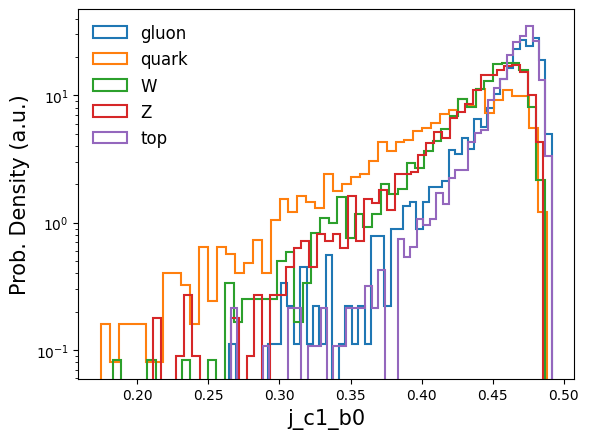

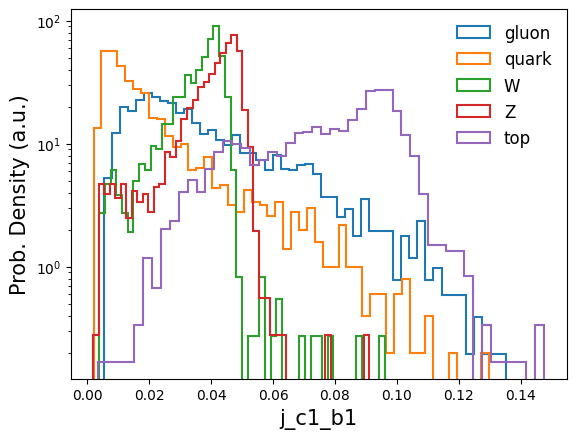

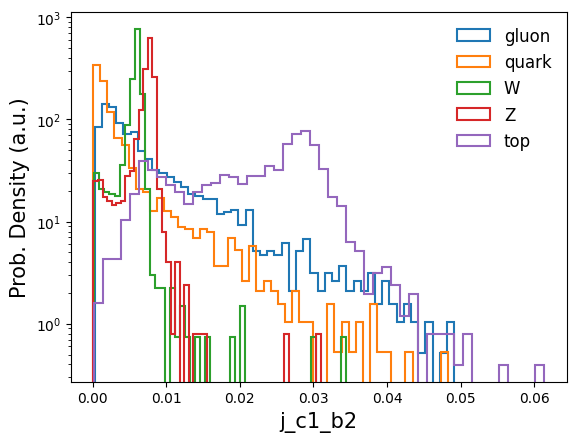

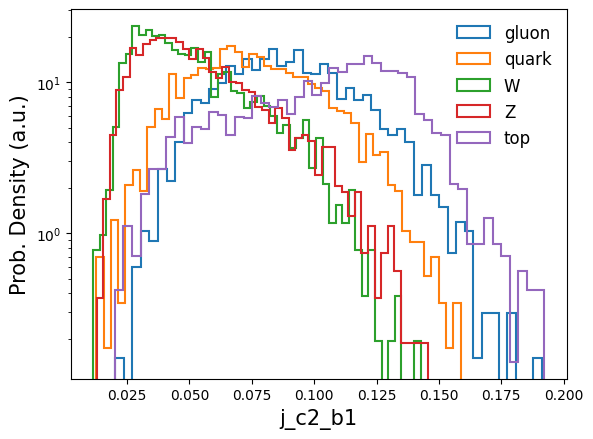

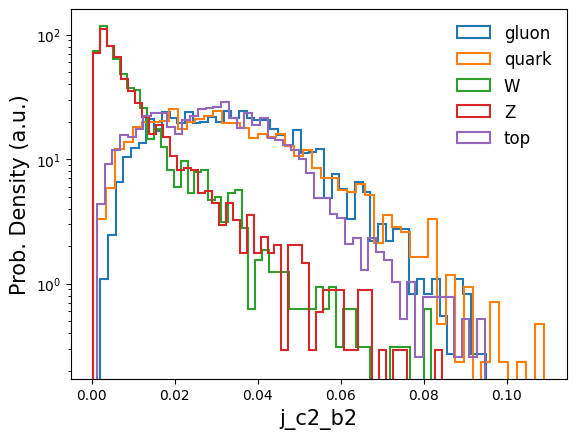

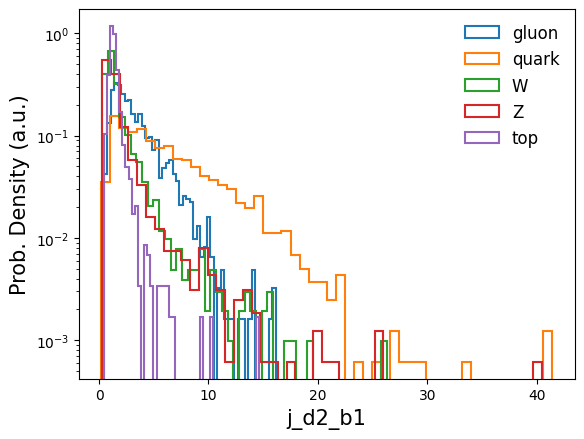

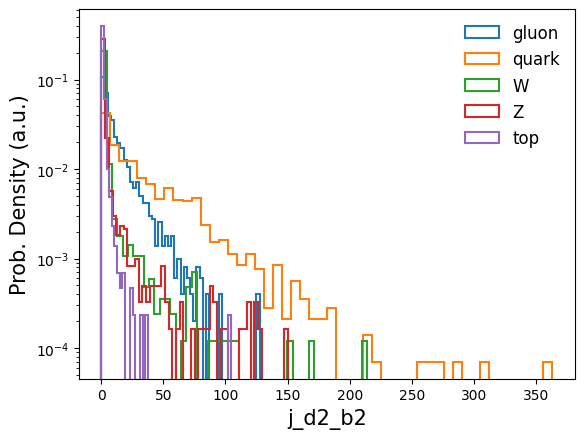

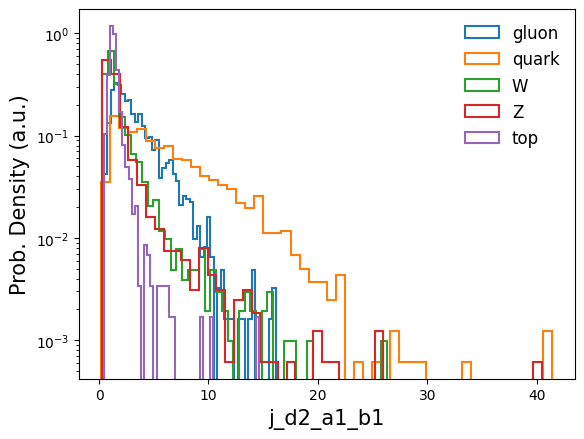

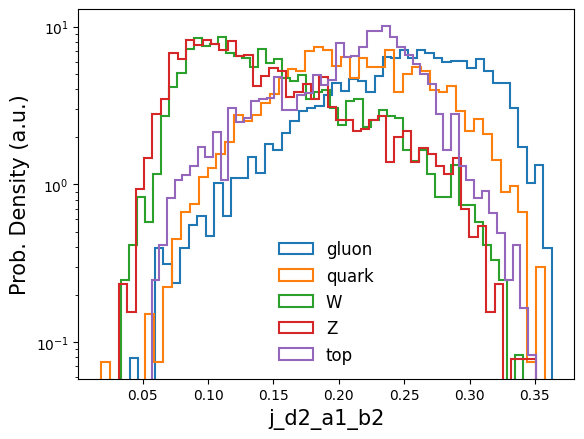

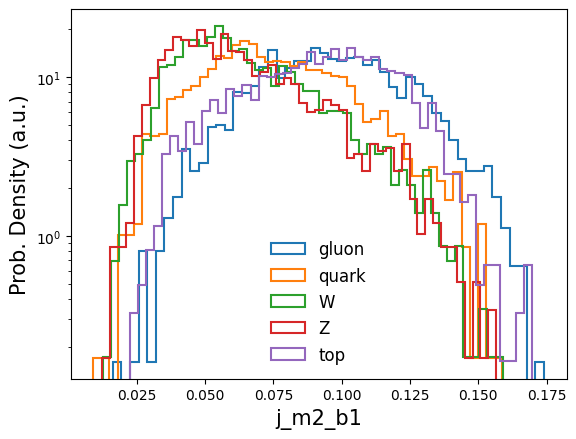

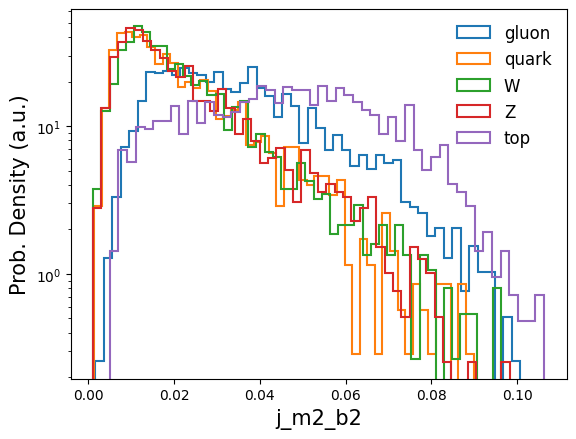

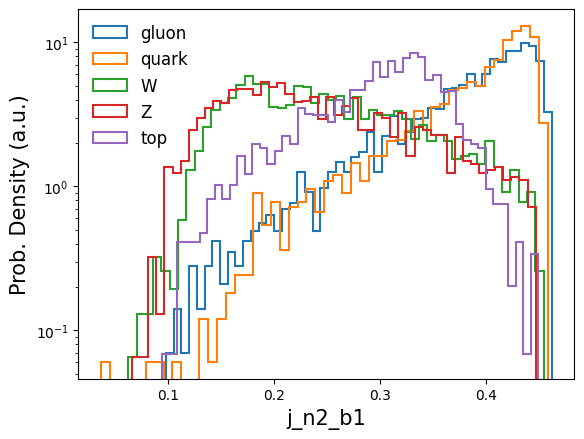

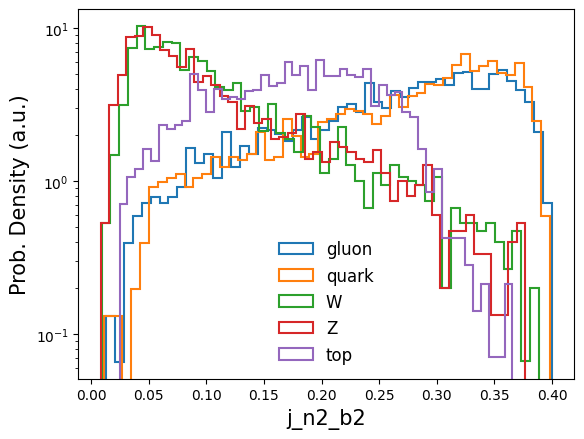

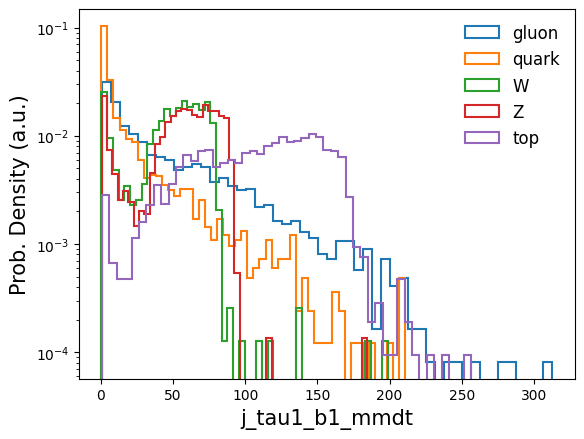

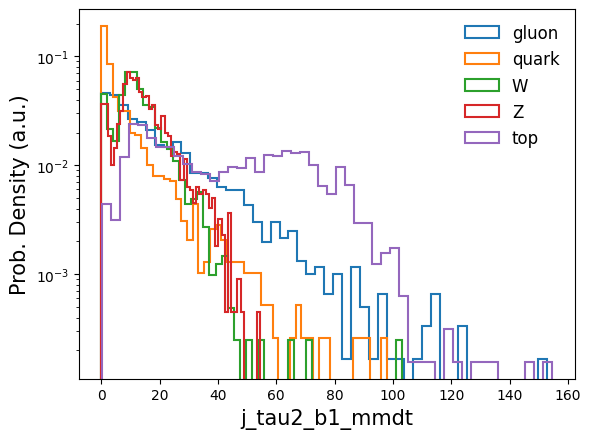

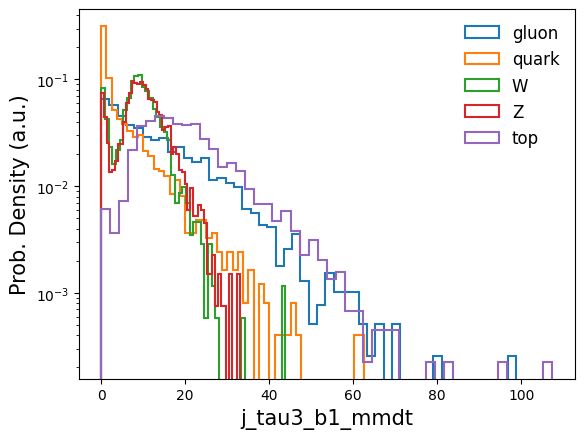

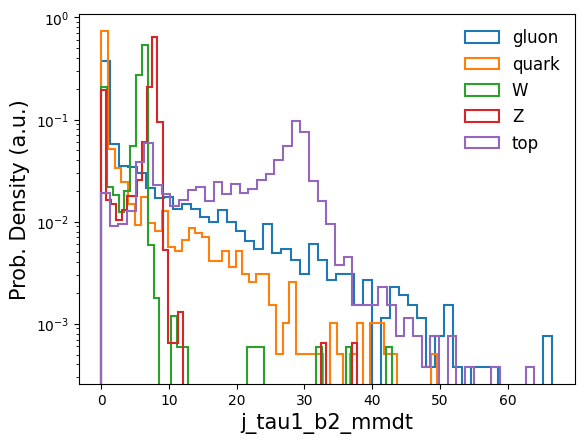

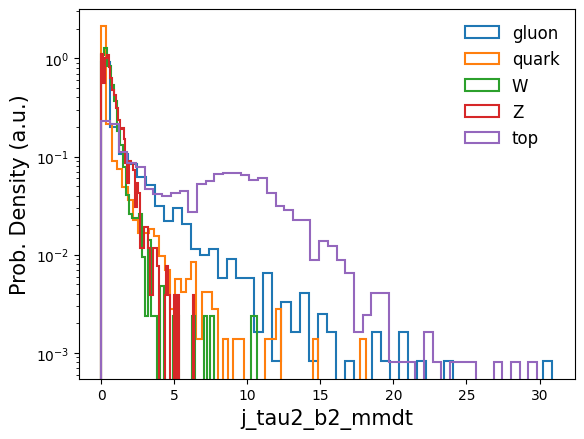

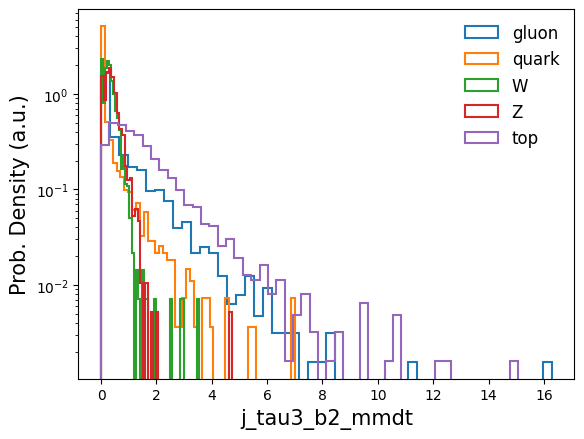

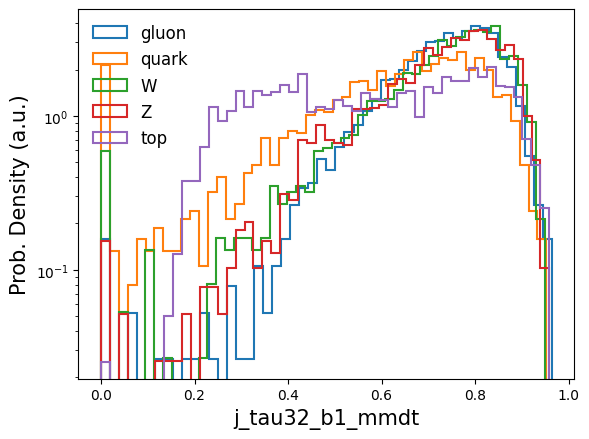

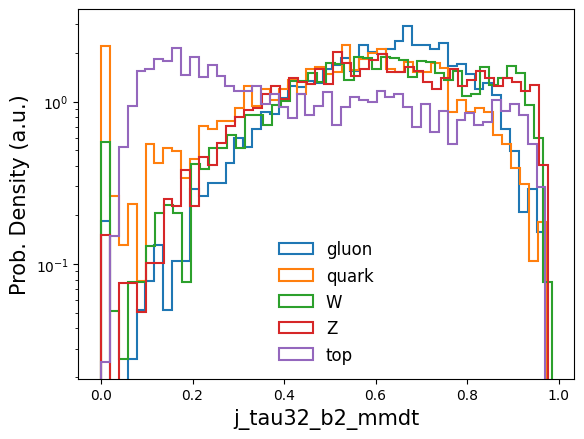

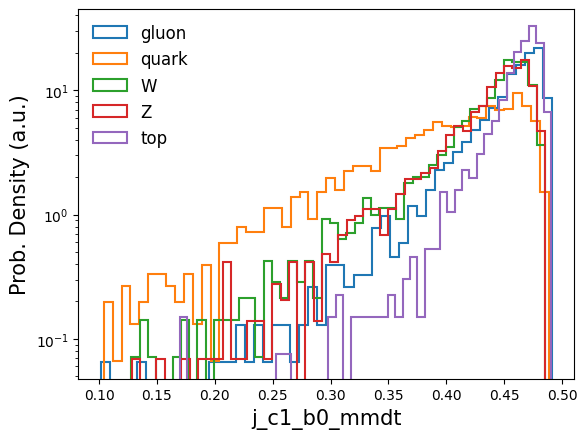

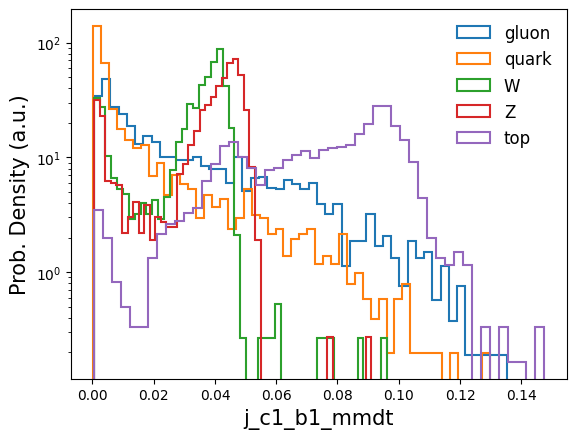

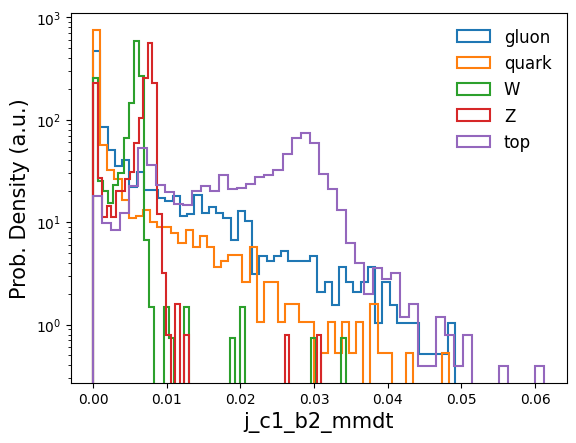

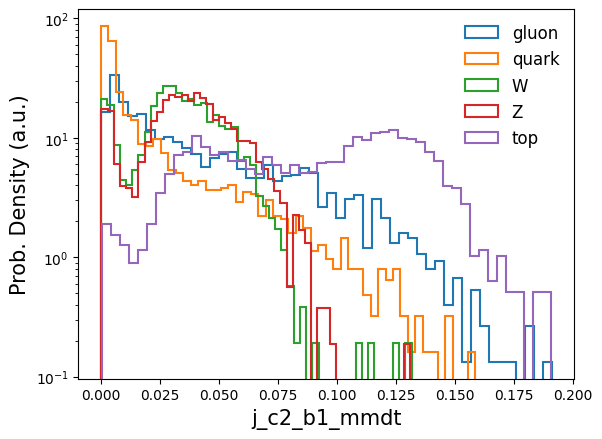

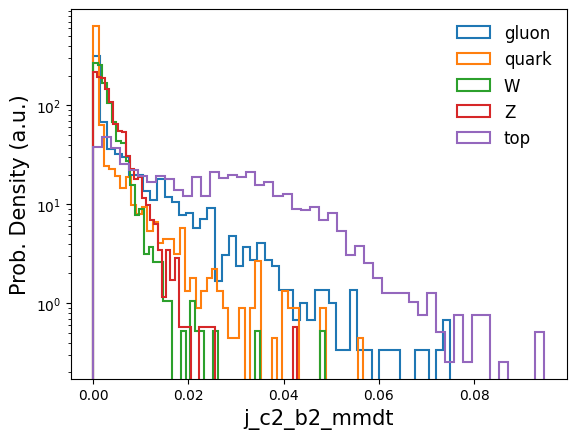

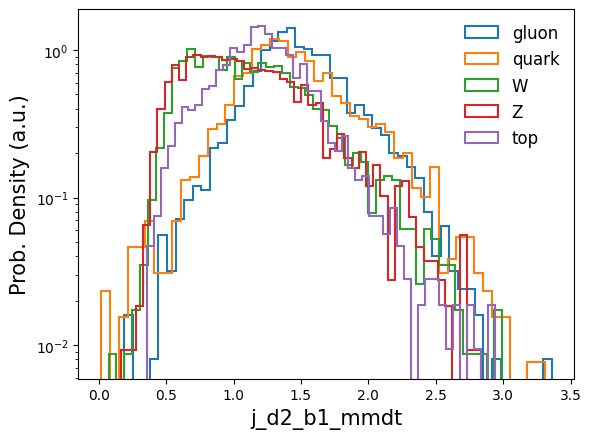

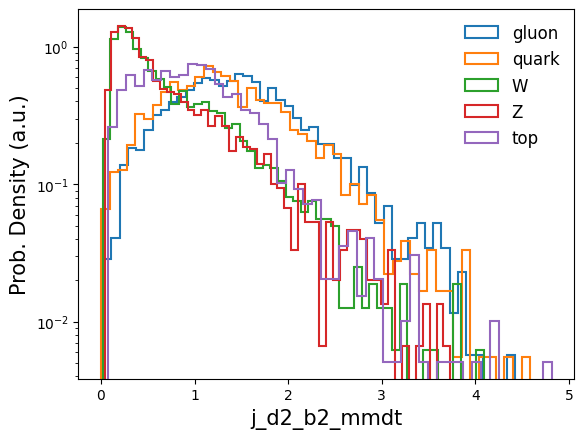

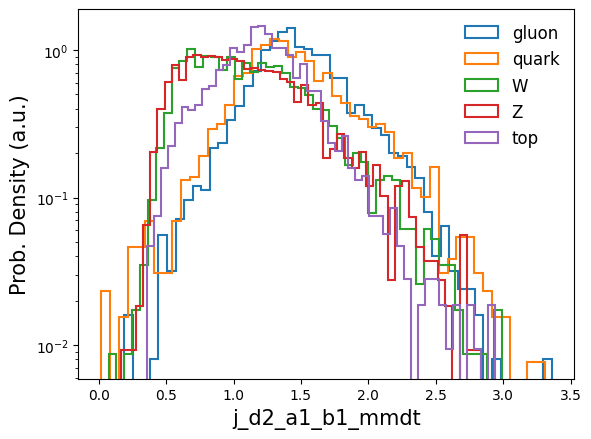

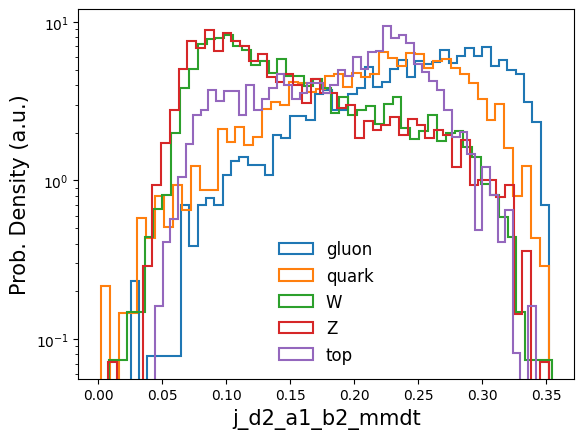

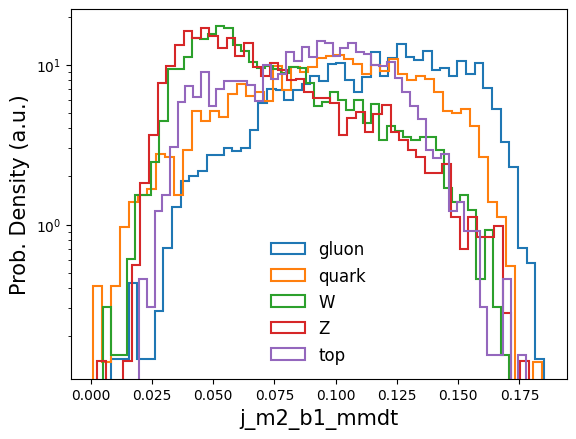

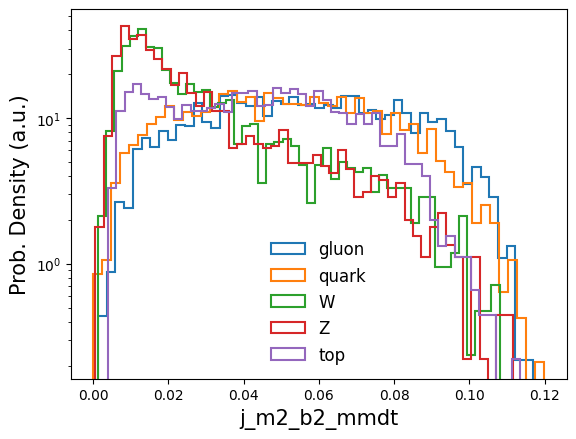

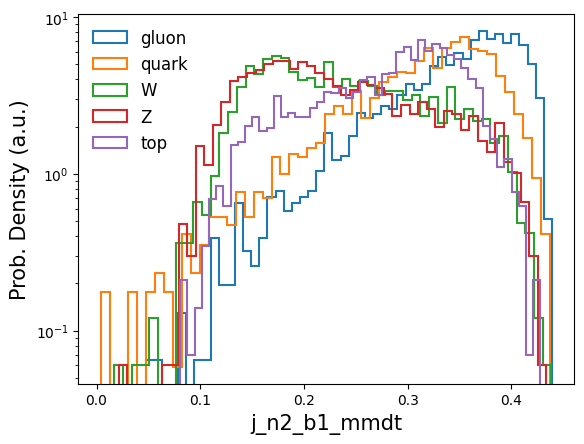

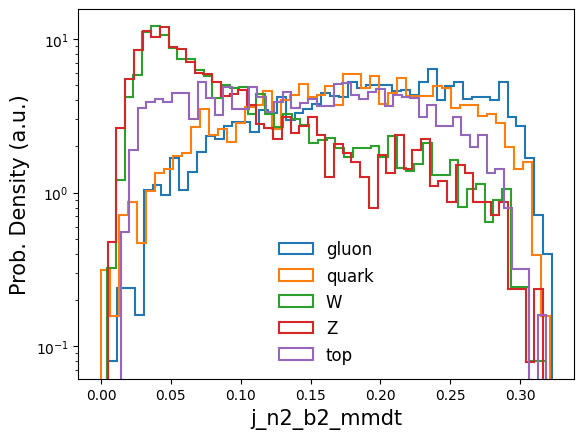

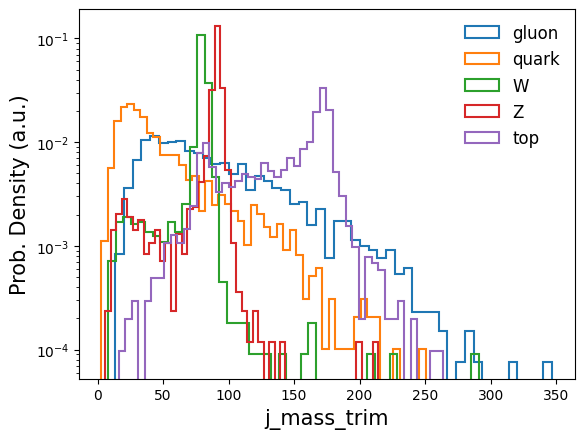

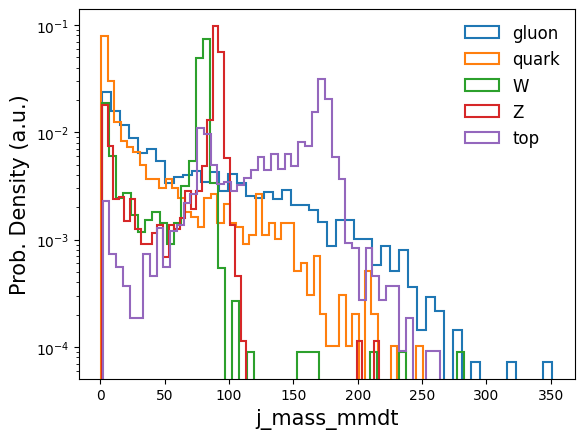

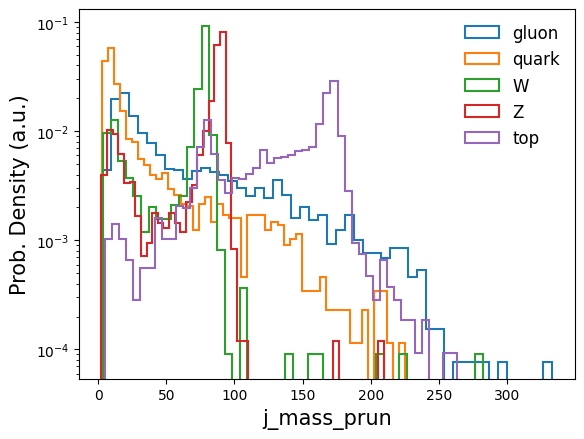

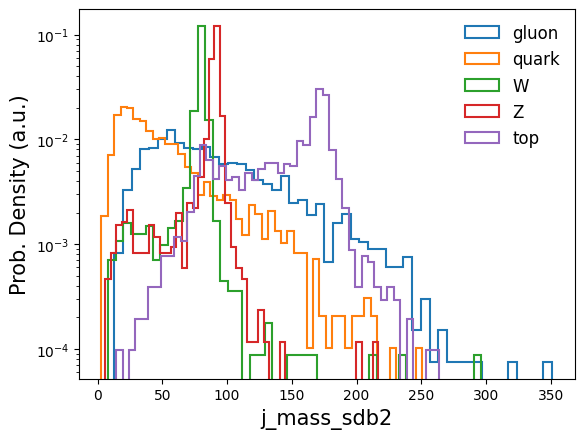

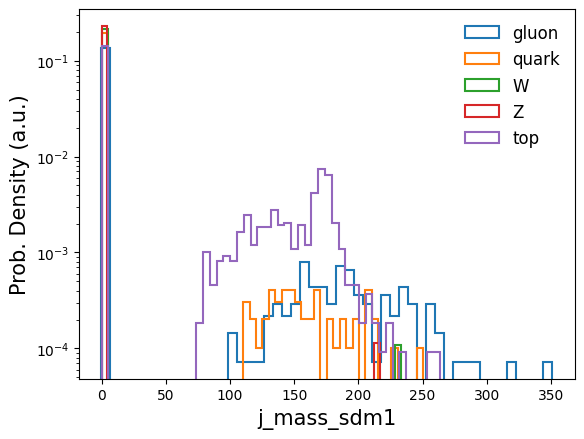

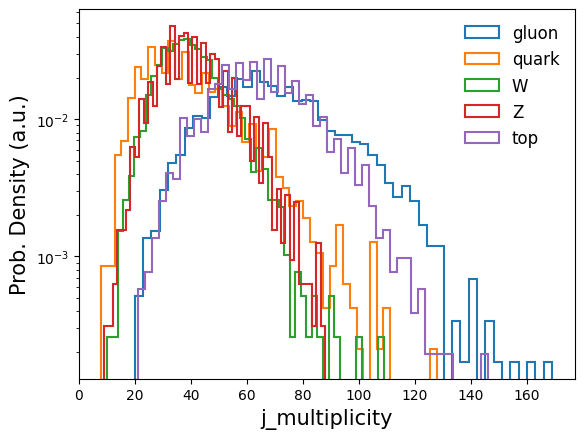

In [ ]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
data = np.array(jet_data[:,:-6])
# this function makes the histogram of a given quantity for the five classes
def makePlot(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        # notice the use of numpy masking to select specific classes of jets
        my_data = input_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index], 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')
    plt.legend(labelCat, fontsize=12, frameon=False)
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

# we now plot all the features
print(len(featurenames[:-6])) #we skip the last 6 elements as those are
#features itself and the uncategorised
for i in range(len(featurenames[:-6])):
    makePlot(i, data, featurenames)

# The image dataset

Jets can be converted to images considering the plane of the solid angle orthogonal to the jet direction, centered along the axis direction and binned. In our case, we consider a square of 1.6x1.6 in size (because the jet size is 0.8 in given units) binned in 100x100 equal-size 'cells'.

In [ ]:
from matplotlib.colors import LogNorm
labelCat= ["gluon", "quark", "W", "Z", "top"]
image = np.array(f.get('jetImage'))
image_g = image[np.argmax(target, axis=1) == 0] #argmax returns the index of the element with the maximum value on the inside of the input list
image_q = image[np.argmax(target, axis=1) == 1]
image_W = image[np.argmax(target, axis=1) == 2]
image_Z = image[np.argmax(target, axis=1) == 3]
image_t = image[np.argmax(target, axis=1) == 4]
images = [image_q, image_g, image_W, image_Z, image_t]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0)
    plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
    plt.colorbar()
    plt.title(labelCat[i], fontsize=15)
    plt.xlabel("$\Delta\eta$ cell", fontsize=15)
    plt.ylabel("$\Delta\phi$ cell", fontsize=15)
    plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-254644052.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta\eta$ cell", fontsize=15)
/tmp/ipython-input-254644052.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta\phi$ cell", fontsize=15)


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 2 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 2 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 2 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 2 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 2 Axes>

# The particle-list dataset

In this case, we look at the particle-related features that we have stored for each jet constituent. The structure of the dataset is similar to that of the physics-motivated features, except for the fact that we have now a double-index dataset: (jet index, particle index). The list is cut at 100 constituents /jet. If less are found, the dataset is completed filling it with 0s (zero padding)

In [ ]:
p_featurenames = f.get("particleFeatureNames")
print(p_featurenames[:])

[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


In [ ]:
p_data = f.get("jetConstituentList")
print(p_data.shape) #10000 jets, 100 particles and 16 different features of the particles

(10000, 100, 16)


In [ ]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot_p(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        my_data = input_data[:,:,feature_index]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    #remark, .flatten() like in topology
    plt.yscale('log')

    plt.legend(labelCat, fontsize=12, frameon=False)
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

# we now plot all the features
for i in range(len(p_featurenames)-1):
    makePlot_p(i, p_data, p_featurenames)

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

# How to read the feature datasets

In [ ]:
target = np.array([])
features = np.array([])
# if we cannot load all data on Colab, we just take a few of them
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,:-6])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, features.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 53)


# How to read the image datasets

In [ ]:
target = np.array([])
jetImage = np.array([])
# if you are running locallt, you can use the full dataset doing
import glob
for fileIN in glob.glob("tutorials/Data/JetDataset/*100p*h5"):#searching for all elements with 100 and h5 in it
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, jetImage.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5


## NOTICE: we have more, so we can add them if you want

# How to read the list datasets

In [ ]:
target = np.array([])
jetList = np.array([])
inputDir = "tutorials/Data/JetDataset" #was originally "tutorials/Data/JetDataset/" causing an //
# we cannot load all data on Colab. So we just take a few files
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
print(target.shape, jetList.shape)

# Task


1.   Train a classifier to identify which particle generated the jets (a task called jet tagging), choosing among the following five possibilities: gluons (g), quarks (q), W bosons (W), Z bosons (Z), and top quarks (t). For this task, you should provide a successful training history, a ROC curve plot with the five classes projected, and a confusion matrix.
2.  Train an AE on quarks and gluons, to identify W, Z and t jets as anomalies. For this task, you should provide a successful training history, a plot showing the distribution of the loss for the standard jets and for the three anomaly classes, and a ROC curve plot with the three anomaly classes.

## Load and Preprocess Data



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1. Select the relevant high-level features and targets.
# 'features' and 'target' arrays are already loaded and preprocessed in previous steps.
X = features  # High-level features
y = target    # One-hot encoded labels

# 2. Split the selected features and targets into training and testing sets (80/20 ratio, stratified).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



print("Data loading and splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data loading and splitting complete.
X_train shape: (40000, 53)
X_test shape: (10000, 53)
y_train shape: (40000, 5)
y_test shape: (10000, 5)


## Part 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

# 1. Initialize a Sequential model
model = Sequential()

# 2. Add the input layer using InputLayer to explicitly define the input shape
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))

# 3. Add a hidden layer
model.add(Dense(64, activation='relu'))

# 4. Add the output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Print the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,493 (60.52 KB)

 Trainable params: 15,493 (60.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# 1. Compile the model
# Use 'categorical_crossentropy' for one-hot encoded labels
# Use 'Adam' optimizer as a common and effective choice
# Track 'accuracy' as a key performance metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compilation complete.")

Model compilation complete.


## Train the Classifier Model



In [ ]:
# 5. Train the model (mini-batch)
# Train the model and store the history
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4852 - loss: 4.9895 - val_accuracy: 0.6778 - val_loss: 1.0838
Epoch 2/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5972 - loss: 1.5225 - val_accuracy: 0.6670 - val_loss: 1.1129
Epoch 3/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6440 - loss: 1.1904 - val_accuracy: 0.5926 - val_loss: 1.4314
Epoch 4/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6656 - loss: 1.0543 - val_accuracy: 0.7208 - val_loss: 0.8487
Epoch 5/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6803 - loss: 0.9859 - val_accuracy: 0.7199 - val_loss: 0.8349
Epoch 6/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7040 - loss: 0.8766 - val_accuracy: 0.6876 - val_loss: 0.8402
Epoch 7/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7211 - loss: 0.8251 - val_accuracy: 0.7196 - val_loss: 0.8203
Epoch 8/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7275 - loss: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7863 - loss: 0.6267

Test accuracy: 0.7864


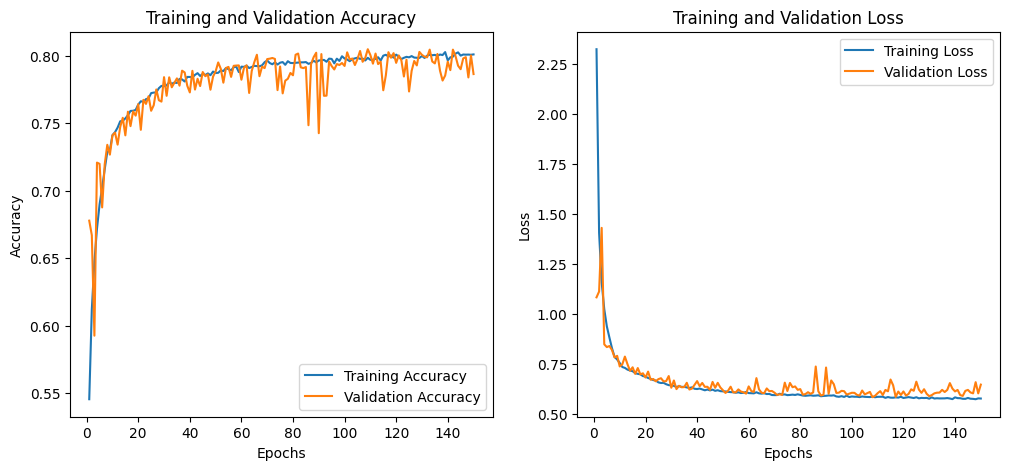

In [ ]:
from keras.utils import to_categorical
# 6. Plot learning curves
# Convert y_test to one-hot encoding
# y_test_cat = to_categorical(y_test, 5) #five features

#we dont need the to_categorial as y_test was already categorised in the loaded file

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")


# Plot training history (accuracy and loss)
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

In [ ]:
# 7. ROC Curves (one-vs-all)
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(5):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve(X_test, y_test, model)

In [ ]:
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(5)), yticklabels=list(range(5)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Part 2 (AE)

Train an AE on quarks and gluons, to identify W, Z and t jets as anomalies. For this task, you should provide a successful training history, a plot showing the distribution of the loss for the standard jets and for the three anomaly classes, and a ROC curve plot with the three anomaly classes.

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
#Remember:
"""[1, 0, 0, 0, 0] for gluons
[0, 1, 0, 0, 0] for quarks
[0, 0, 1, 0, 0] for Ws
[0, 0, 0, 1, 0] for Zs
[0, 0, 0, 0, 1] for tops """

gluons = np.array([1,0,0,0,0])
quarks = np.array([0,1,0,0,0])
w = np.array([0,0,1,0,0])
z = np.array([0,0,0,1,0])
t = np.array([0,0,0,0,1])
print(y_train.shape)
print(y_train[0:6])
print(np.where(np.all(y_train==w, axis=1))[0])

# Task


## Filter and Prepare Data for AE



In [ ]:
# Extract normal (background) digits (excluding digit 5)
normal_indices = np.where(np.logical_or(np.all(y_train == gluons, axis=1), np.all(y_train == quarks, axis=1)))[0] #the wehere is a numpy mask; I am taking all the 5 on the side
anomaly_indices = np.where(np.logical_or(np.logical_or(np.all(y_train == w, axis=1), np.all(y_train == z, axis=1)), np.all(y_train == t, axis=1)))[0]
x_normal = X_train[normal_indices]
x_anomalies = X_train[anomaly_indices]

print(f"Shape of x_normal: {x_normal.shape}")
print(f"Shape of x_anomalies: {x_anomalies.shape}")

In [ ]:
# Split the normal digits into train, validation, and test sets (50%, 25%, 25%)
x_train_normal, x_temp  = train_test_split(x_normal, test_size=0.5, random_state=42)
x_val_normal, x_test_normal = train_test_split(x_temp, test_size=0.5, random_state=42)

In [ ]:
# Combine validation set with anomalies (label 0 for background, 1 for anomalies)
x_val = np.concatenate([x_val_normal, x_anomalies], axis=0)
y_val = np.concatenate([np.zeros(len(x_test_normal)), np.ones(len(x_anomalies))], axis=0)
# shuffle them if you want. Not really needed

In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Dense, Reshape, BatchNormalization, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K


In [ ]:
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded) # Latent dimension
    encoded = Dense(16, activation='relu')(encoded)

    # Decoder
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_shape[0], activation='linear')(decoded) # Output layer with linear activation for reconstruction

    autoencoder = Model(input_layer, decoded)
    return autoencoder

In [ ]:
# Build the autoencoder model
input_shape = (53,) #as we have 53 features in a one-dimensional array
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

In [ ]:
# Compile the model
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [ ]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the autoencoder on the training data
history = autoencoder.fit(x_train_normal, x_train_normal,
                          epochs=20,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(x_val_normal, x_val_normal),#he is cheating by using it twice; gets fixed (14.10.2025)
                          callbacks=[early_stopping])

In [ ]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Calculate MSE for the test dataset
x_out_test = autoencoder.predict(X_test)
mse_test = np.mean(np.square(X_test - x_out_test), axis=1)

In [ ]:


y_test_classes = np.argmax(y_test, axis=1) # Get the class index for each sample

# Create a binary label: 0 for normal (gluon/quark), 1 for anomaly (W/Z/top)
y_test_anomaly_binary = np.where( np.logical_or(y_test_classes == 0,y_test_classes == 1), 0, 1)

# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_test[y_test_anomaly_binary == 0], label='Normal (Gluon/Quark)', color='blue', kde=True)
sns.histplot(mse_test[y_test_anomaly_binary == 1], label='Anomalies (W/Z/top)', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_anomaly_binary, mse_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()